In [52]:
from src import TARS, markets, portfolios, traders, strategies
%matplotlib inline

# Koker strategy - in development

Here's an example to show how you can develop your own strategy. This notebook is a template for you to start your own thing.

### Here's the strategy in development

It's actually a copy of the TrendFollowingMACD.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Koker:

    def __init__(self):
        self.x = None
        self.x_train = None
        self.x_test = None
        self.theta = None
        self.sharpes = None

    def load(self, data):
        """
        Load a dataframe with the data and create the training and test set.
        The column with the timestamp must be labelled 'utc' and the one with
        price, "price".

        :param data: DataFrame
        """
        data.index = pd.to_datetime(data.index, unit='s')
        rets = data['price'].diff()[1:]

        x = np.array(rets)
        self.x = x

        N = 1000
        P = 200
        x_train = x[-(N+P):-P]
        x_test = x[-P:]

        std = np.std(x_train)
        mean = np.mean(x_train)

        self.x_train = (x_train - mean) / std
        self.x_test = (x_test - mean) / std

    @staticmethod
    def sharpe_ratio(rets):
        return rets.mean() / rets.std()

    @staticmethod
    def positions(x, theta):
        M = len(theta) - 2
        T = len(x)
        Ft = np.zeros(T)
        for t in range(M, T):
            xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
            Ft[t] = np.tanh(np.dot(theta, xt))
        return Ft

    @staticmethod
    def returns(Ft, x, delta):
        T = len(x)
        rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
        return np.concatenate([[0], rets])

    @staticmethod
    def gradient(x, theta, delta):
        Ft = Koker.positions(x, theta)
        R = Koker.returns(Ft, x, delta)
        T = len(x)
        M = len(theta) - 2

        A = np.mean(R)
        B = np.mean(np.square(R))
        S = A / np.sqrt(B - A ** 2)

        dSdA = S * (1 + S ** 2) / A
        dSdB = -S ** 3 / 2 / A ** 2
        dAdR = 1. / T
        dBdR = 2. / T * R

        grad = np.zeros(M + 2)  # initialize gradient
        dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta

        for t in range(M, T):
            xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
            dRdF = -delta * np.sign(Ft[t] - Ft[t - 1])
            dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t - 1])
            dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
            dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (
                        dRdF * dFdtheta + dRdFp * dFpdtheta)
            grad = grad + dSdtheta
            dFpdtheta = dFdtheta

        return grad, S

    def train(self, x, epochs=2000, M=8, commission=0.0025, learning_rate=0.3):
        print("training : start")
        theta = np.random.rand(M + 2)
        sharpes = np.zeros(epochs)  # store sharpes over time
        for i in range(epochs):
            grad, sharpe = Koker.gradient(x, theta, commission)
            theta = theta + grad * learning_rate
            sharpes[i] = sharpe
        self.theta = theta
        self.sharpes = sharpes
        print("training : completed")

    def plot(self, x, theta):
        x_returns = Koker.returns(Koker.positions(x, theta), x, 0.0025)
        plt.plot(x_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
        plt.plot(x.cumsum(), label="Buy and Hold", linewidth=1)
        plt.xlabel('Ticks')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.title("RL Model vs. Buy and Hold")


In [51]:
import pandas as pd
from ta.trend import MACD

from src.tars.evaluators.trader_evaluator import TraderEvaluator
from src.tars.strategies.abstract_strategy import AbstractStrategy
from src.tars.markets.crypto_market import CryptoMarket


class KokerStrategy(AbstractStrategy):
    """
    Koker Strategy

    :param trader: Trader
        The Trader handling a portfolio
    :param pair: str
        The pair e.g. XETHZUSD to buy and hold
    :param volume: float
        The volume of the pair's quote buy
    :param validate: boolean
        Safety Boolean to make sure not to trade real money by default

    :ivar evaluator: AbstractEvaluator
        Evaluator allows for the evaluation of a strategy
    :ivar market: AbstractMarket
        Market object to get information from
    """

    def __init__(self, trader, pair, volume, validate=True):
        self.name = 'My strategy'
        self.trader = trader
        self.pair = pair
        self.volume = volume
        self.validate = validate
        self.evaluator = TraderEvaluator(self.trader)
        self.market = CryptoMarket()

    def run(self):
        """ Run the strategy """
        # 1. Add a checkpoint to the evaluator
        balance = self.trader.portfolio.get_trade_balance().loc['eb'].ZUSD   
        self.evaluator.add_checkpoint(pd.Timestamp.utcnow(), balance)
        
        # 2. Process the data
        market = CryptoMarket()
        df0 = market.get_ohlc_data(pair=self.pair)[0]['close'].iloc[::-1]

        # 3. Get the relevant signal informations
        macd = MACD(df0)
        line = macd.macd()[-1]
        signal = macd.macd_signal()[-1]

        # 4. Implement the trading logic
        if signal < line:
            self.trader.add_order(pair=self.pair, type='buy',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
        elif signal >= line:
            self.trader.add_order(pair=self.pair, type='sell',
                                  ordertype='market', volume=self.volume,
                                  validate=self.validate)
        else:
            pass


## Instanciate Tars

Then, it is as usual.

In [3]:
api_key = f'../kraken.key'

In [4]:
portfolio_1 = portfolios.VirtualPortfolio({'ZUSD': 1000})
trader_1 = traders.VirtualCryptoTrader(portfolio_1)
strategy_1 = strategies.BuyAndHold(trader_1, 'XETHZUSD', 0.2)

portfolio_2 = portfolios.VirtualPortfolio({'ZUSD': 1000})
trader_2 = traders.VirtualCryptoTrader(portfolio_2)

# Here's where you use your newly developed strategy
strategy_2 = MyStrategy(trader_2, 'XETHZUSD', 0.2)

In [5]:
# Create Tars and load its strategies
tars = TARS()
tars.load(strategy_1)
tars.load(strategy_2)

 🤖 TARS : Welcome to Endurance! 👨‍🚀
 🤖 TARS : Loaded strategy ➡️ Buy and hold
 🤖 TARS : Loaded strategy ➡️ My strategy


## Start the bot

In [6]:
tars.start('00:00:10')

 🤖 TARS : Starting trading session 📈
 ⏱ Trading decision will be taken every : 00:00:10️ (hh:mm:ss)
 💪️ Loading :   
   🧵 'Thread-4' ➡️ 'Buy and hold'
   🧵 'Thread-5' ➡️ 'My strategy'


## Evaluate the strategy

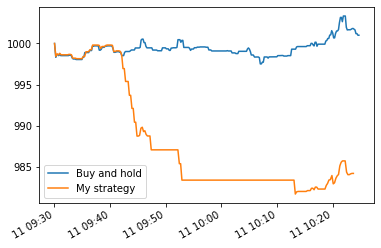

In [53]:
tars.plot()

In [42]:
tars.evaluate().tail()

,Buy and hold,My strategy
2021-08-11 09:36:00+00:00,998.90,999.00
2021-08-11 09:37:00+00:00,999.67,999.81
2021-08-11 09:38:00+00:00,999.19,999.77
2021-08-11 09:39:00+00:00,999.67,999.63
2021-08-11 09:40:00+00:00,999.71,999.81


## Stop the bot

In [28]:
tars.stop()

 🤖 TARS : ✋ Stopped all strategies


---